# Verb Collocations with Atelic Time Duration Adverbials:
## A Collostructional Approach

In this notebook, I develop procedures to select and analyze atelic, durative time phrases within Biblical Hebrew. In English these phrases are communicated with the "for" construction: e.g. X happened for three days. These phrases are important since they are used in telicity tests for lexical aspect. The fundamental assumption is that atelic durative time phrases do not normally combine with telic verb lexemes:

> Durative adverbials also have an aspectual feature: they state specific bounds of a situation. They are compatible with durative atelic verb constellations and statives, and incompatible with durative telic verb constellations...(Smith, *The Parameter of Aspect*, 1997: 113)

In Fuhs' 2010 study, ["The Aspectual Coercion of the English Durative Adverbial,"](https://philpapers.org/rec/FUHTAC) he tests this assumption using collostruction analysis. This method, developed by Stefanowitsch and Gries ([see description here](http://www.linguistics.ucsb.edu/faculty/stgries/research/2003_AS-STG_Collostructions_IJCL.pdf)), tests the collocational preferences between a given construction and other lexical items. Those preferences are measured through a statistical test for significance, the Fisher's Exact test. Fuhs finds that 75% of the verb lexemes found to be statistically associated with atelic durative time adverbials do indeed have atelic aspect. Yet 25% of the verbs were truly telic. Fuhs also checks whether these 25% occur in the progressive aspect, which can construe telic action duratively. He finds that they do not, meaning that these cases are truly telic verb lexemes being construed as atelic. These findings suggest that the relationship between temporal adverbials and lexical aspect is more complex than is sometimes understood. 

In this notebook, I seek to apply Fuhs' methodology to the atelic durative time adverbials of Biblical Hebrew, to see whether his results are paralleled in the Biblical Hebrew data. The first step is to identify which forms in Biblical Hebrew indicate atelic, durative functions. The ETCBC Hebrew syntax database indicates adjunct phrases with a function of communicating "Time." For this pilot study, these phrases will serve as the primary target of investigation.

In [the exploratory analysis](SBH_time_expressions.ipynb), I found that noun-phrase based time adverbials have two primary forms: NPs governed by a preposition (PP), and bare NPs. Amongst these two groups are further divisions between noun phrases modified with a quantifier or a demonstrative (including the demonstrative ה). A preliminary search leading up to this pilot study futher found that the durative atelic time construction in Biblical Hebrew appears to be conveyed by bare NP's without any demonstrative element, often with quantification or plurality. While demonstratives or prepositions locate an event within a metaphorical space (e.g. this = near, that = far), bare noun phrases have no element which pinpoints a point or range along a timeline. Quantifiers and plural endings, by contrast, only serve to modify the length of time duration, and do not indicate positionality along a timeline. The result, then, is that the functional emphasis on time adverbials without prepositions or demonstratives falls on the duration itself. 

That durative, atelic time constructions in Biblical Hebrew are not directionally marked makes Biblical Hebrew similar to most other world languages, as Haspelmath observes:

> The most striking tendency observed in the expression of atelic-extent adverbials is the cross-linguistic tendency for zero expression or expression by means of a "minimal case". (Haspelmath 1997: 120)

Haspelmath points out that English is among a few other Indo-European languages that employ a preposition such as "for" to indicate atelic duration, while the majority use the zero-marking described above.

In [1]:
# ETCBC's BHSA data
from tf.app import use

# stats & data-containers
import collections, random
import pandas as pd
import numpy as np
import scipy.stats as stats
from pyscripts.significance import contingency_table, apply_fishers
from pyscripts.pca import plot_PCA
from sklearn.decomposition import PCA

# data visualizations
import seaborn as sns
sns.set(font_scale=1.5, style='whitegrid')
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# load BHSA and heads data
A = use('bhsa', mod='etcbc/heads/tf,CambridgeSemiticsLab/BH_time_collocations/tf', hoist=globals())
A.displaySetup(condenseType='clause') # configure Hebrew display
TF.load('g_cons_utf8 trailer_utf8', add=True)

TF app is up-to-date.
Using annotation/app-bhsa commit 7f353d587f4befb6efe1742831e28f301d2b3cea (=latest)
  in /Users/cody/text-fabric-data/__apps__/bhsa.
Using etcbc/bhsa/tf - c rv1.6 in /Users/cody/text-fabric-data
Using etcbc/phono/tf - c r1.2 in /Users/cody/text-fabric-data
Using etcbc/parallels/tf - c r1.2 in /Users/cody/text-fabric-data
Using etcbc/heads/tf - c rv.1.11 in /Users/cody/text-fabric-data
Using CambridgeSemiticsLab/BH_time_collocations/tf - c rv1.1 in /Users/cody/text-fabric-data


**Documentation:** <a target="_blank" href="https://etcbc.github.io/bhsa" title="provenance of BHSA = Biblia Hebraica Stuttgartensia Amstelodamensis">BHSA</a> <a target="_blank" href="https://annotation.github.io/text-fabric/Writing/Hebrew" title="('Hebrew characters and transcriptions',)">Character table</a> <a target="_blank" href="https://etcbc.github.io/bhsa/features/hebrew/c/0_home.html" title="BHSA feature documentation">Feature docs</a> <a target="_blank" href="https://github.com/annotation/app-bhsa" title="bhsa API documentation">bhsa API</a> <a target="_blank" href="https://annotation.github.io/text-fabric/Api/Fabric/" title="text-fabric-api">Text-Fabric API 7.4.6</a> <a target="_blank" href="https://annotation.github.io/text-fabric/Use/Search/" title="Search Templates Introduction and Reference">Search Reference</a>

  0.00s loading features ...
  0.01s All additional features loaded - for details use loadLog()


In [2]:
def reverse_hb(hb_text):
    return ''.join(reversed(hb_text))

def barplot_counts(count_dict, title='', reverse_labels=False, size=(8, 6), text_size=14, rotation=None, limit=None):
    '''
    Makes simple barplot from collections.Counter type objects.
    '''
    
    count_df = pd.DataFrame.from_dict(count_dict, orient='index', columns=['count']).sort_values(ascending=False, by='count')
    plotme = count_df.head(limit) if limit else count_df
    
    n_bars = list(range(0, plotme.shape[0]))
    x_labels = [''.join(reversed(prep)) for prep in plotme.index] if reverse_labels else plotme.index
    plt.figure(figsize=size)
    sns.barplot(n_bars, plotme['count'], color='darkblue')
    plt.xticks(n_bars, x_labels, size=text_size, rotation=rotation)
    plt.yticks(size=text_size)
    plt.title(title, size=text_size)
    plt.ylabel('count', size=text_size)
    plt.show()
    return count_df

## Functional Clustering

In order to compare the durative function to other functions, we need to validate whether the unmarked forms discussed above truly cluster together as distinguished from other functions. Additionally, in order to test significance between a verbal lexeme and a function, we need to gather contingency data for other functions in the Hebrew Bible. 

In this section, I lay out an approach to semantic clustering, which is based in part on the methods I applied in [a study of noun semantics](www.codykingham.com/nouns2018). In that study, nouns were clustered together based on the similarities of their syntactic and lexical contexts. In this study, we already know that the selected phrases have an identical semantic function of indicating Time, but we want to further distinguish species, especially aspectual connotations, amongst the time phrases. When comparing nouns, one can count contexts with respect to a given lexeme. But how does one count contexts with respect to a phrase function?

In the intial [SBH_time_expressions](SBH_time_expressions.ipynb) study, we saw a few important divisions within the SBH materials. Let's have a look at the distributions within the whole Hebrew Bible.

### Analysis of Time Phrase Types

4080 time phrases found...




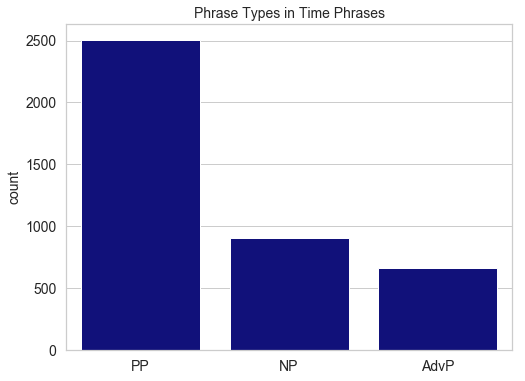

,count
PP,2507
NP,905
AdvP,668


In [3]:
phrase_type = A.search('''

phrase function=Time

''', shallow=True, silent=True)

print(len(phrase_type), 'time phrases found...\n\n')

p_type_count = collections.Counter()
for phrase in phrase_type:
    p_type_count[F.typ.v(phrase)] += 1
    
p_type_count = barplot_counts(p_type_count, title='Phrase Types in Time Phrases')
    
display(p_type_count)

### The Problem of Test Clusters

In a previous study on noun semantics, I applied automated semantic analysis to the top 199 occurring nouns in the corpus. If we take the surface form of the time adverbials, do we have enough data to develop rudimentary clusters?

I have decided to initially focus on PP and NP types and treat AdvP separately on a later occasion (following Haspelmath 1997).

For certain values we fill in placeholder to create more grouping:
* cardinal number lexemes are replaced by: `C`

In [4]:
time_phrases = A.search('''

phrase function=Time
/with/
typ=NP
/or/
typ=PP
<nhead- word pdp=subs
/-/

''', shallow=True)

tp_tokens = collections.Counter()
token2phrase = collections.defaultdict(list)

def tokenizeTP(wordnode):
    '''Builds tokens for time phrase words based on my criteria.'''
    if F.ls.v(wordnode) == 'card':
        return 'C'
    else:
        return F.g_cons_utf8.v(wordnode) or 'ה'
    
    
for tp in time_phrases:
    # develop a surface token without vocalization / accents
    token = '.'.join(tokenizeTP(w) for w in L.d(tp, 'word'))
    tp_tokens[token] += 1
    token2phrase[token].append(tp)
    
print(f'{len(time_phrases)} time phrases counted...')

  0.69s 3204 results
3204 time phrases counted...


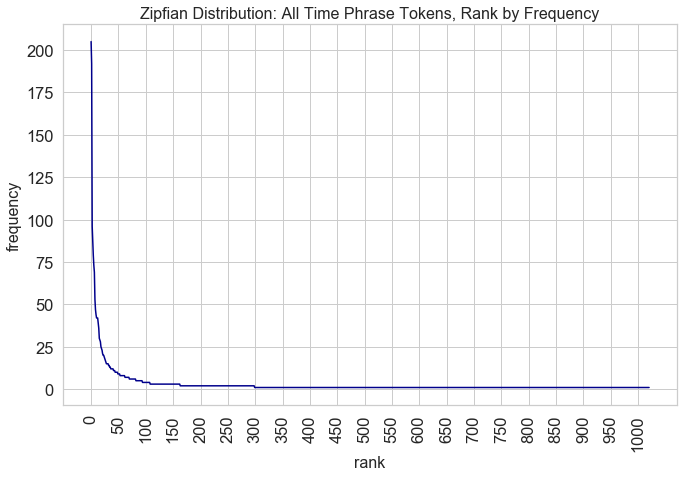

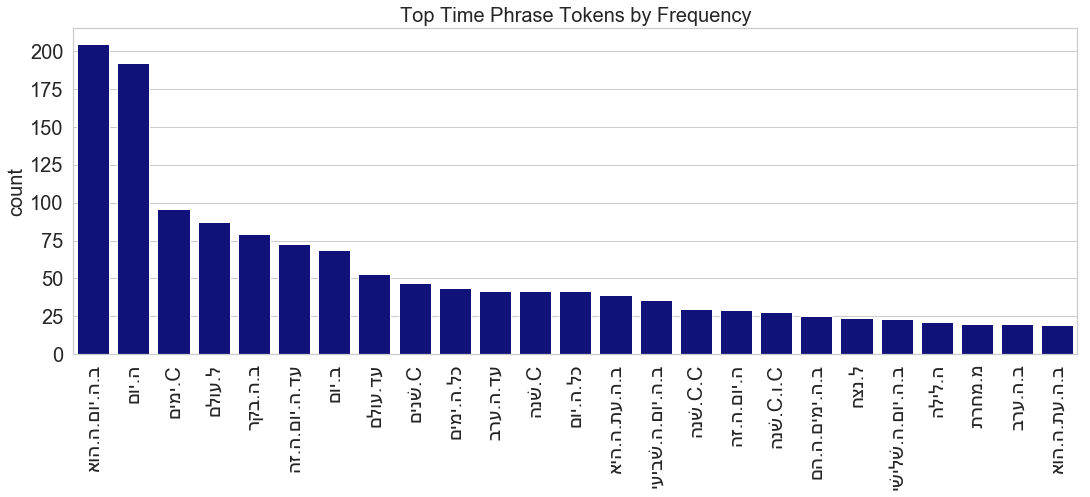

In [5]:
display(HTML(f'<h5>total number of TP tokens: {len(tp_tokens)}</h5>'))
print('\n\n')
plt.figure(figsize=(11, 7))
plt.plot(np.arange(len(tp_tokens)), sorted(tp_tokens.values(), reverse=True), color='darkblue')
plt.title('Zipfian Distribution: All Time Phrase Tokens, Rank by Frequency', size=16)
plt.xlabel('rank', size=16)
plt.ylabel('frequency', size=16)
plt.xticks(np.arange(0, len(tp_tokens), step=50), rotation='vertical')
    
tp_surface_ct = barplot_counts(tp_tokens, 
                               size=(18, 6), 
                               reverse_labels=True, 
                               title='Top Time Phrase Tokens by Frequency',
                               rotation='vertical', 
                               text_size=20,
                               limit=25)

### Examine test-set frequencies

In [6]:
# get number of items with freq >= 10


tp_surface_ct[tp_surface_ct['count'] >= 10].shape

(49, 1)

In [7]:
toptokens = tp_surface_ct[tp_surface_ct['count'] >= 10]

toptokens

,count
ב.ה.יום.ה.הוא,205
ה.יום,192
C.ימים,96
ל.עולם,87
ב.ה.בקר,79
עד.ה.יום.ה.זה,73
ב.יום,69
עד.עולם,53
C.שׁנים,47
כל.ה.ימים,44


In [8]:
toptokens.sum() # number of potential samples

count    1693
dtype: int64

There are 49 tokens with a frequency >= 10. This may be a good set to begin with. Let's look at those with 5 occurrences...

### Determine Set Size with Requirements

The set should contain predicates in each case. How much does that shrink the pool?

In [9]:
token2count = collections.Counter()

for token in toptokens.index:
    
    limit = A.search(f'''

clause
    {token}
    phrase function=Pred|PreS|PreO
    
    ''', sets=token2phrase, silent=True)
    
    token2count[token] += len(limit)
    
tokencounts = pd.DataFrame.from_dict(token2count, orient='index', columns=['count']).sort_values(ascending=False, by='count')

tokencounts

,count
ב.ה.יום.ה.הוא,197
ה.יום,113
C.ימים,90
ב.ה.בקר,74
ל.עולם,73
עד.ה.יום.ה.זה,64
ב.יום,55
C.שׁנים,44
עד.עולם,43
עד.ה.ערב,42


In [10]:
tokencounts.shape

(49, 1)

After checking for predicates, the remaining data is sufficient to continue on with the analysis.

## Statistical Analysis of Tokens

Following a similar strategy to my work on nouns, we apply here a statistical analysis of the surface forms above. Specifically, we are looking for collocation tendencies in two areas: the first is with certain verb lexemes, and the second is with verb conjugations. The result will be two tables that we will clean and prepare for PCA cluster analysis.

In [11]:
def disambigUTF8(wordnode):
    '''
    Adds modified ETCBC disambiguators 
    to UTF8 lexical forms.
    '''
    letters = [letter for letter in F.lex.v(wordnode)]
    gloss_number = letters.count('=') + 1 if {'[', '/'}&set(letters) else '' # count = (etcbc disambiguator)
    wordtype = 'n' if '/' in letters else 'v' if '[' in letters else ''
    utf8 = F.lex_utf8.v(wordnode)
    disambigs = [dis for dis in [utf8, wordtype+str(gloss_number)] if dis] # remove null strings (e.g. in cases of preps)
    return '.'.join(disambigs)

def tag_verb(verb_node):
    '''
    Constructs a stem+lemma verb token.
    '''
    verb_stem = F.vs.v(verb_node)
    verb_lex = disambigUTF8(verb_node)
    return f'{verb_lex}.{verb_stem}'

In [12]:
raw_lex_counts = collections.defaultdict(lambda: collections.Counter())
raw_conj_counts = collections.defaultdict(lambda: collections.Counter())
basis2lex = collections.defaultdict()

token2lex2results = collections.defaultdict(lambda: collections.defaultdict(list))
token2conj2results = collections.defaultdict(lambda: collections.defaultdict(list))

tp_pattern = '''

clause
    {}
    phrase function=Pred|PreS|PreO
        word pdp=verb
'''

for token in toptokens.index:
    
    results = A.search(tp_pattern.format(token), sets=token2phrase, silent=True)
    print(f'{token}\tresults: {len(results)}')
    
    for result in results:
        clause, tphrase, pphrase, verb = result
        verb_tag = tag_verb(verb)
        verb_conj = F.vt.v(verb)
        raw_lex_counts[token][verb_tag] += 1
        raw_conj_counts[token][verb_conj] += 1
        basis2lex[verb_tag] = L.u(verb, 'lex')[0]
        token2lex2results[token][verb_tag].append(result) 
        token2conj2results[token][verb_conj].append(result) 
         
lex_counts = pd.DataFrame(raw_lex_counts).fillna(0)
conj_counts = pd.DataFrame(raw_conj_counts).fillna(0)

display(lex_counts.head())
display(conj_counts.head())

ב.ה.יום.ה.הוא	results: 197
ה.יום	results: 113
C.ימים	results: 90
ל.עולם	results: 73
ב.ה.בקר	results: 74
עד.ה.יום.ה.זה	results: 64
ב.יום	results: 55
עד.עולם	results: 43
C.שׁנים	results: 44
כל.ה.ימים	results: 37
עד.ה.ערב	results: 42
C.שׁנה	results: 40
כל.ה.יום	results: 26
ב.ה.עת.ה.היא	results: 36
ב.ה.יום.ה.שׁביעי	results: 32
C.C.שׁנה	results: 29
ה.יום.ה.זה	results: 25
C.ו.C.שׁנה	results: 28
ב.ה.ימים.ה.הם	results: 18
ל.נצח	results: 24
ב.ה.יום.ה.שׁלישׁי	results: 20
ה.לילה	results: 18
מ.מחרת	results: 19
ב.ה.ערב	results: 17
ב.ה.עת.ה.הוא	results: 17
ימים.רבים	results: 17
C.חדשׁים	results: 13
ב.ה.לילה	results: 10
ב.ה.לילה.ה.הוא	results: 14
ל.עלם	results: 11
ב.C.ל.ה.חדשׁ	results: 13
ל.פנים	results: 8
ב.ה.יום.ה.שׁמיני	results: 12
ב.עצם.ה.יום.ה.זה	results: 14
ב.יום.ה.שׁבת	results: 8
ב.ימיו	results: 13
ב.ה.בקר.ב.ה.בקר	results: 11
ל.עד	results: 9
ב.כל.עת	results: 8
כל.ה.לילה	results: 9
ב.אחרית.ה.ימים	results: 12
ב.ה.צהרים	results: 11
עד.בקר	results: 10
עד.ה.בקר	results: 10
ב.עת	results: 8
מ.יום	res

,ב.ה.יום.ה.הוא,ה.יום,C.ימים,ל.עולם,ב.ה.בקר,עד.ה.יום.ה.זה,ב.יום,עד.עולם,C.שׁנים,כל.ה.ימים,...,כל.ה.לילה,ב.אחרית.ה.ימים,ב.ה.צהרים,עד.בקר,עד.ה.בקר,ב.עת,מ.יום,ב.ה.יום.ה.שׁני,בין.ה.ערבים,ב.יום.C
אבד.v1.piel,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
אבד.v1.qal,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
אבל.v1.hif,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
אבל.v1.hit,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
אהב.v1.qal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,ב.ה.יום.ה.הוא,ה.יום,C.ימים,ל.עולם,ב.ה.בקר,עד.ה.יום.ה.זה,ב.יום,עד.עולם,C.שׁנים,כל.ה.ימים,...,כל.ה.לילה,ב.אחרית.ה.ימים,ב.ה.צהרים,עד.בקר,עד.ה.בקר,ב.עת,מ.יום,ב.ה.יום.ה.שׁני,בין.ה.ערבים,ב.יום.C
impf,56.0,25.0,40.0,48.0,10,3.0,18.0,22.0,7.0,8.0,...,0.0,5.0,5.0,8.0,4.0,1.0,0.0,1.0,7.0,4.0
impv,0.0,6.0,4.0,3.0,8,0.0,2.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
infa,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
infc,1.0,8.0,1.0,6.0,3,1.0,2.0,5.0,0.0,10.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
perf,75.0,62.0,26.0,14.0,9,24.0,25.0,13.0,22.0,15.0,...,2.0,7.0,3.0,1.0,0.0,3.0,8.0,2.0,1.0,2.0


#### Dimensions of the Data and Adjustments

In [13]:
lex_counts.shape

(360, 49)

In [14]:
conj_counts.shape

(6, 49)

Number of verbs only observed once:

In [15]:
hapax = lex_counts.sum(1)[lex_counts.sum(1) == 1]
hapax.shape

(188,)

Drop those verbs...

In [16]:
lex_data = lex_counts.drop(hapax.index)

#### Size of the New Lex Dataset

In [17]:
lex_data.shape

(172, 49)

Check to see whether any TPs have been eliminated...

In [18]:
lex_data.sum().min()

5.0

The minimum count in the dataset is 5, not zero. That is what is wanted.

#### Fisher's Exact Adjustments

In [19]:
lextransf = apply_fishers(lex_data)
conjtransf = apply_fishers(conj_counts)

In [20]:
lextransf.head()

,ב.ה.יום.ה.הוא,ה.יום,C.ימים,ל.עולם,ב.ה.בקר,עד.ה.יום.ה.זה,ב.יום,עד.עולם,C.שׁנים,כל.ה.ימים,...,כל.ה.לילה,ב.אחרית.ה.ימים,ב.ה.צהרים,עד.בקר,עד.ה.בקר,ב.עת,מ.יום,ב.ה.יום.ה.שׁני,בין.ה.ערבים,ב.יום.C
אבד.v1.piel,0.000000,0.000000,0.000000,0.00000,0.000000,1.042816,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,1.952173
אבד.v1.qal,0.353710,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
אבל.v1.hit,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,1.100176,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
אכל.v1.nif,0.284971,0.000000,0.522851,0.00000,0.000000,0.000000,0.775667,0.0,0.0,0.000000,...,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000
אכל.v1.qal,-0.249540,2.096802,3.004733,-0.19862,0.424224,0.000000,0.000000,0.0,0.0,0.000000,...,0.0,0.0,0.77827,0.0,0.0,0.0,0.0,0.0,0.73661,0.879184


In [21]:
conjtransf

,ב.ה.יום.ה.הוא,ה.יום,C.ימים,ל.עולם,ב.ה.בקר,עד.ה.יום.ה.זה,ב.יום,עד.עולם,C.שׁנים,כל.ה.ימים,...,כל.ה.לילה,ב.אחרית.ה.ימים,ב.ה.צהרים,עד.בקר,עד.ה.בקר,ב.עת,מ.יום,ב.ה.יום.ה.שׁני,בין.ה.ערבים,ב.יום.C
impf,-0.132364,-1.069028,2.578617,10.221394,-2.821350,-6.104110,0.186005,2.477832,-1.351852,-0.441084,...,-1.184984,0.451107,0.497156,2.856793,0.306113,-0.347895,-1.184984,-0.529258,2.019641,0.334318
impv,-1.983821,1.294138,0.564680,0.378481,3.591799,-0.397104,0.408823,0.000000,-0.205230,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.851181,0.000000,0.000000,0.000000,0.000000,0.000000
infa,0.000000,0.000000,0.000000,0.000000,0.998965,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
infc,-2.355301,1.150202,-0.597455,1.254667,0.119991,-0.291244,0.000000,1.666642,-0.387175,6.341453,...,0.000000,0.000000,0.456400,0.000000,0.000000,0.571195,0.000000,0.000000,0.490007,0.527928
perf,0.198795,4.414485,-0.849012,-2.789596,-5.571314,0.048418,0.806217,-0.370705,1.103915,0.217061,...,-0.300805,0.868384,-0.121929,-0.982624,-1.773812,-0.000000,2.738271,-0.300805,-0.982624,-0.300805
wayq,1.143840,-5.066583,-0.743682,-7.671368,7.618675,6.017439,-1.518399,-3.726369,0.508447,-1.626323,...,2.611183,-1.351299,-0.132470,-0.521511,-0.000000,0.159901,-0.338910,1.788053,-0.521511,0.000000


##### Fisher's Exploration

In [22]:
lextransf.max(1).sort_values(ascending=False).head()

טמא.v1.qal     47.930501
שׁכם.v1.hif    35.770950
מלך.v1.qal     18.534252
סגר.v1.hif     10.640404
יתר.v1.hif      8.906363
dtype: float64

In [23]:
pd.DataFrame(conjtransf.max().sort_values(ascending=False)).head(10)

,0
מ.מחרת,10.764344
ל.עולם,10.221394
ב.ה.בקר,7.618675
ל.נצח,7.238220
כל.ה.ימים,6.341453
עד.ה.יום.ה.זה,6.017439
ב.ה.לילה.ה.הוא,5.053714
ל.עד,4.783922
ה.יום,4.414485
C.C.שׁנה,3.224802


In [24]:
conjtransf['מ.מחרת'].sort_values(ascending=False)

wayq    10.764344
infc     0.000000
infa     0.000000
impv     0.000000
impf    -2.770142
perf    -3.459826
Name: מ.מחרת, dtype: float64

In [25]:
conjtransf['ל.עולם'].sort_values(ascending=False)

impf    10.221394
infc     1.254667
impv     0.378481
infa     0.000000
perf    -2.789596
wayq    -7.671368
Name: ל.עולם, dtype: float64

# PCA Analyses

## Clustering with Verb Lexeme Attraction Scores

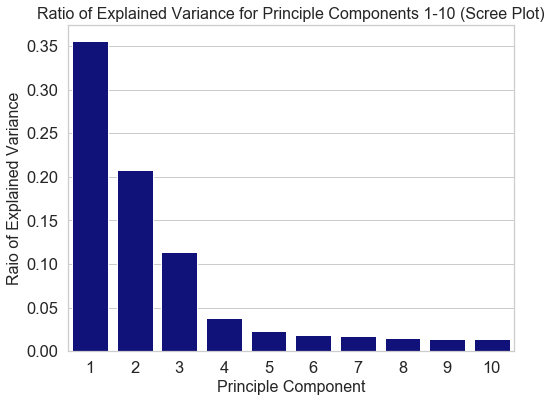

In [51]:
pca = PCA(10)
lex_fit = pca.fit(lextransf.T.values)
pca_lexs = lex_fit.transform(lextransf.T.values)

lexloadings = lex_fit.components_.T * np.sqrt(lex_fit.explained_variance_)
lexloadings = pd.DataFrame(lexloadings.T, index=np.arange(10)+1, columns=lextransf.index)


plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(10)+1, y=lex_fit.explained_variance_ratio_[:10], color='darkblue')
plt.xlabel('Principle Component', size=16)
plt.ylabel('Raio of Explained Variance', size=16)
plt.title('Ratio of Explained Variance for Principle Components 1-10 (Scree Plot)', size=16)
plt.show()

### PC1 and PC2

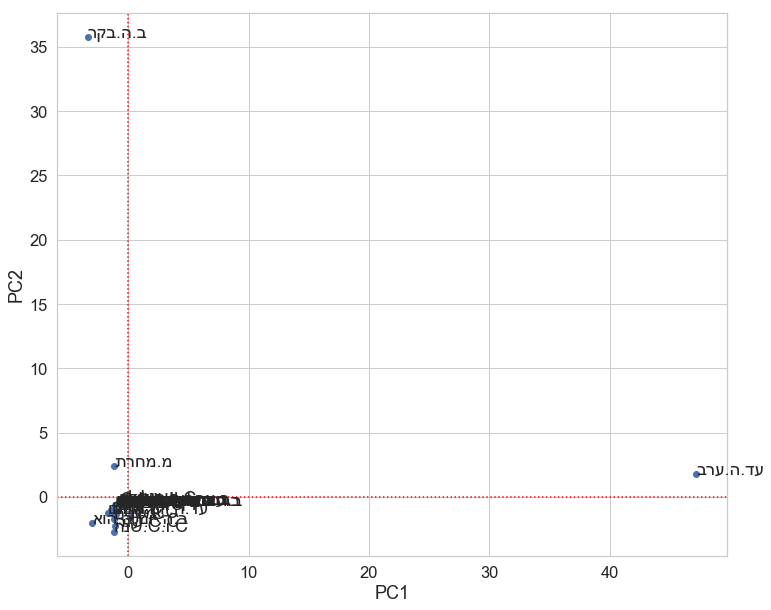

In [27]:
plot_PCA(pca_lexs, components=(pca_lexs[:,0], pca_lexs[:,1]), annoTags=[reverse_hb(token) for token in lextransf.columns])

In [157]:
basis2lex[lex]

1439529

In [163]:
F.lex_utf8.v(L.d(1439529, 'word')[0])

'אבד'

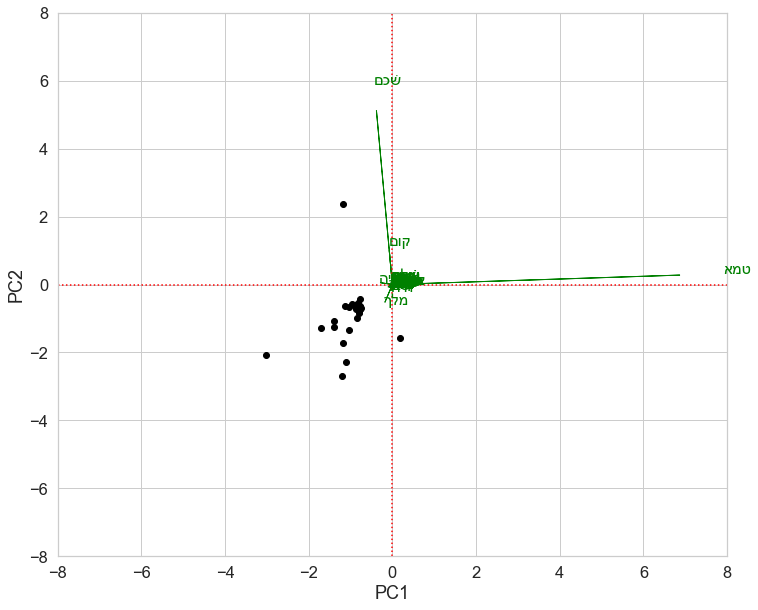

In [177]:
x, y = (pca_lexs[:,0], pca_lexs[:,1])

# plot coordinates
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black')
plt.xlabel('PC1', size=18)
plt.ylabel('PC2', size=18)
plt.axhline(color='red', linestyle=':')
plt.axvline(color='red', linestyle=':')

zoom = (-8, 8, -8, 8)
plt.xlim(zoom[0], zoom[1])
plt.ylim(zoom[2], zoom[3])

for lex in lexloadings:
    x, y = lexloadings[lex][:2]
    plt.arrow(0, 0, x, y, color='green')
    
    # handle zooms
    if any([x < zoom[0], x > zoom[1], y < zoom[2], y > zoom[3]]):                
        continue
        
    plt.annotate(reverse_hb(F.lex_utf8.v(L.d(basis2lex[lex], 'word')[0])), xy=(x*1.15, y*1.15), color = 'green', size=16)

#plt.savefig('plots/duration/conj_PCA_biplot.png', dpi=300)
    
plt.show()

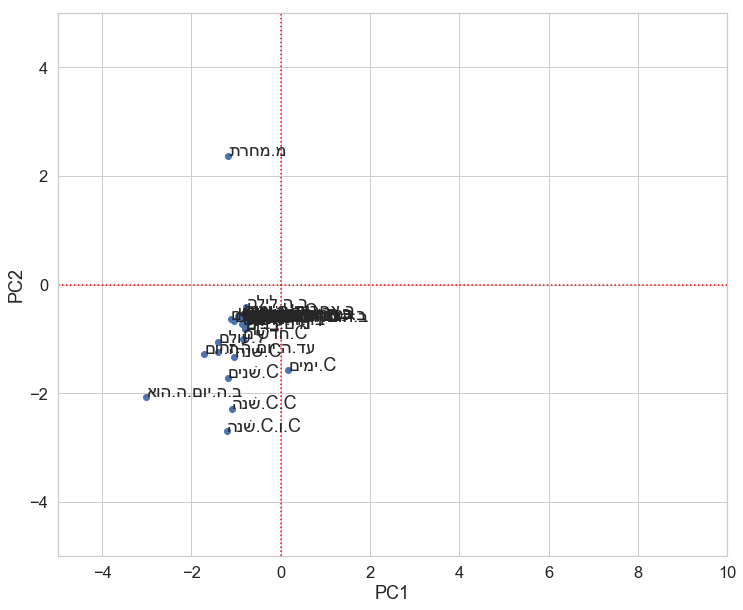

In [29]:
plot_PCA(pca_lexs, zoom=((-5, 10, -5, 5)), components=(pca_lexs[:,0], pca_lexs[:,1]), annoTags=[reverse_hb(token) for token in lextransf.columns])

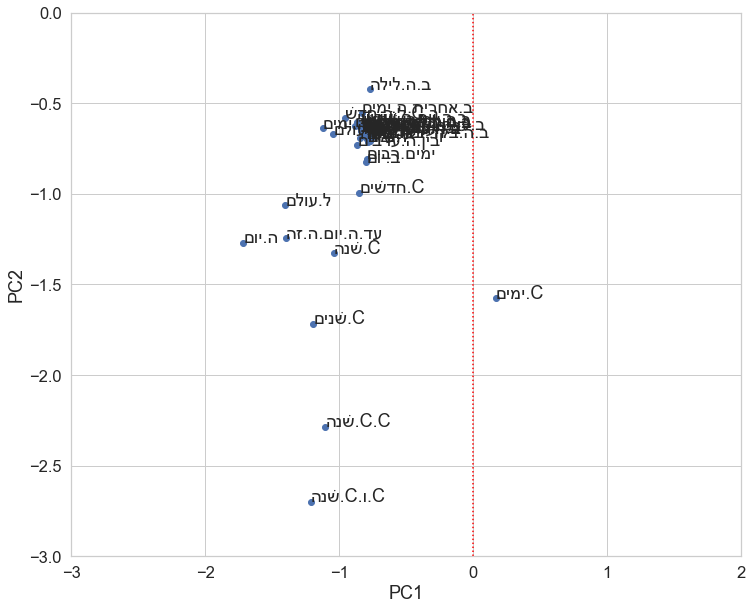

In [30]:
plot_PCA(pca_lexs, zoom=((-3, 2, -3, 0)), components=(pca_lexs[:,0], pca_lexs[:,1]), annoTags=[reverse_hb(token) for token in lextransf.columns])

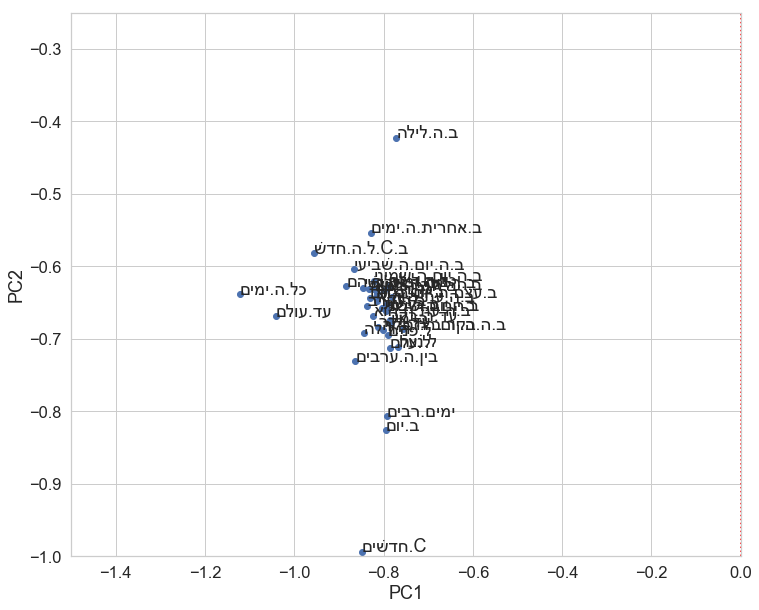

In [39]:
plot_PCA(pca_lexs, zoom=((-1.5, 0, -1, -0.25)), components=(pca_lexs[:,0], pca_lexs[:,1]), annoTags=[reverse_hb(token) for token in lextransf.columns])

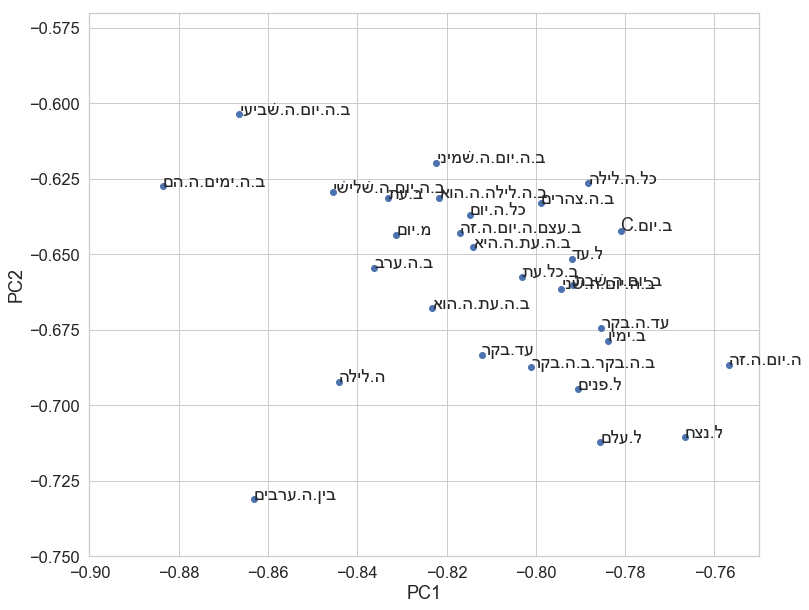

In [49]:
plot_PCA(pca_lexs, zoom=((-0.90, -0.75, -.75, -0.57)), components=(pca_lexs[:,0], pca_lexs[:,1]), annoTags=[reverse_hb(token) for token in lextransf.columns])

#### Loading Scores and Contexts

What influences the first or second principle components?

In [58]:
lexloadings.loc[1].sort_values(ascending=False).head(10)

טמא.v1.qal     6.866242
צום.v1.qal     0.253210
לקט.v1.piel    0.163731
סגר.v1.nif     0.145004
נפל.v1.qal     0.136895
בכה.v1.qal     0.136403
אכל.v1.qal     0.013617
סגר.v1.hif     0.007406
עשׂה.v1.nif    0.001811
חגג.v1.qal     0.001811
Name: 1, dtype: float64

In [62]:
lexloadings.loc[2].sort_values(ascending=False).head(15)

שׁכם.v1.hif     5.115058
קום.v1.qal      1.002981
טמא.v1.qal      0.276883
שׁלח.v1.piel    0.136418
שׁמר.v1.nif     0.136395
מות.v1.hif      0.135754
בין.v1.hit      0.108856
זרע.v1.qal      0.100390
שׁמע.v1.qal     0.072626
היה.v1.qal      0.053581
אמר.v1.qal      0.051242
נגד.v1.hif      0.041073
אכל.v1.qal      0.024069
דבר.v1.piel     0.022485
הלך.v1.qal      0.012014
Name: 2, dtype: float64

In [63]:
lexloadings.loc[2].sort_values().head(15)

מלך.v1.qal    -0.520951
חיה.v1.qal    -0.177908
ישׁב.v1.qal   -0.130557
נתן.v1.qal    -0.087239
קרא.v1.qal    -0.074471
עבד.v1.qal    -0.074153
עשׂה.v1.qal   -0.072491
סגר.v1.hif    -0.064695
שׁפט.v1.qal   -0.055526
ידע.v1.qal    -0.034872
שׁקט.v1.qal   -0.034834
לין.v1.qal    -0.030854
יצא.v1.qal    -0.029830
צוה.v1.piel   -0.027983
פשׁע.v1.qal   -0.027982
Name: 2, dtype: float64

### PC2 and PC3

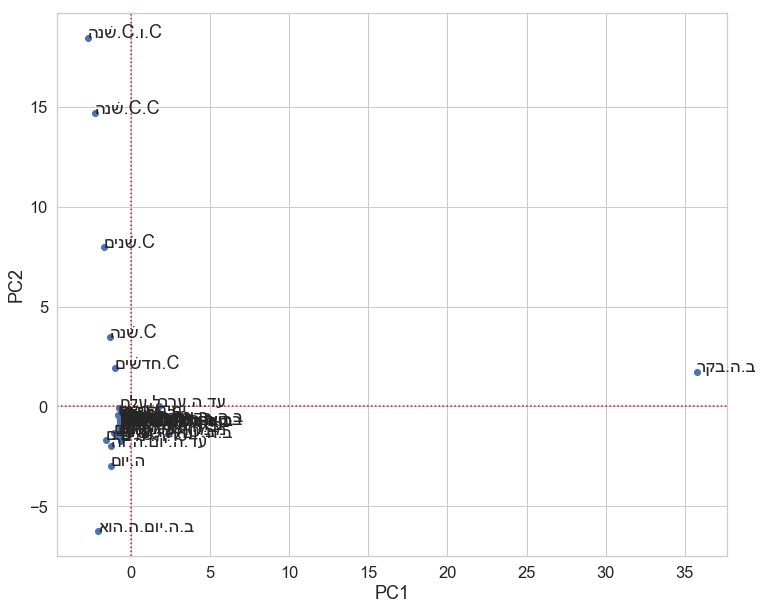

In [55]:
plot_PCA(pca_lexs, components=(pca_lexs[:,1], pca_lexs[:,2]), annoTags=[reverse_hb(token) for token in lextransf.columns])

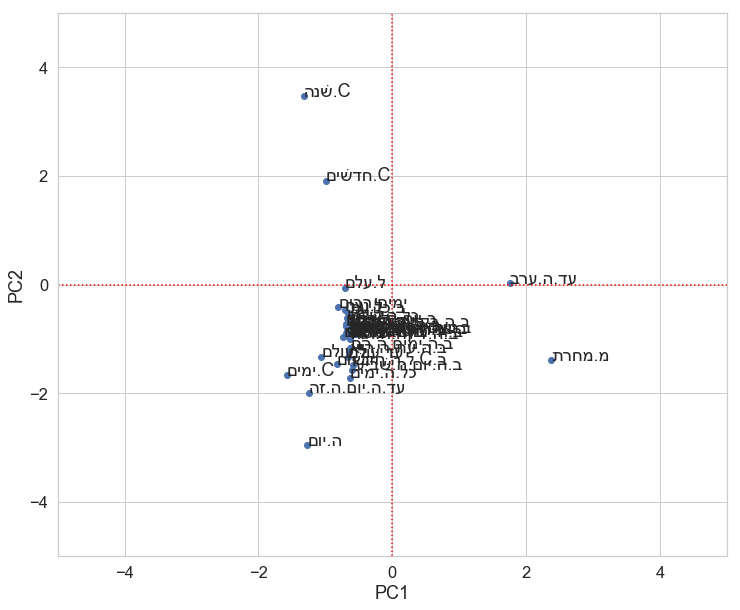

In [38]:
plot_PCA(pca_lexs, zoom=((-5, 5, -5, 5)), components=(pca_lexs[:,1], pca_lexs[:,2]), annoTags=[reverse_hb(token) for token in lextransf.columns])

In [67]:
lexloadings.loc[3].sort_values(ascending=False).head(15)

מלך.v1.qal     3.569257
חיה.v1.qal     1.079498
עבד.v1.qal     0.501623
שׁכם.v1.hif    0.385388
שׁפט.v1.qal    0.331118
בנה.v1.qal     0.130515
שׁקט.v1.qal    0.119974
זרע.v1.qal     0.113868
טמא.v1.qal     0.085793
הלך.v1.hif     0.068696
קום.v1.qal     0.068647
מרד.v1.qal     0.064088
הלך.v1.hit     0.060450
ישׁב.v1.qal    0.059053
צור.v1.qal     0.046630
Name: 3, dtype: float64

In [66]:
lexloadings.loc[3].sort_values().head(15)

היה.v1.qal    -0.663036
עשׂה.v1.qal   -0.155215
ידע.v1.qal    -0.115240
קרא.v1.qal    -0.101756
נתן.v1.qal    -0.094089
ירא.v1.qal    -0.092583
סגר.v1.hif    -0.088051
יצא.v1.qal    -0.077384
זבח.v1.qal    -0.075358
ישׁע.v1.hif   -0.074600
אמר.v1.qal    -0.074268
כרת.v1.qal    -0.071906
עוד.v1.hif    -0.067216
שׁוב.v1.qal   -0.061043
נגד.v1.hif    -0.059645
Name: 3, dtype: float64

#### PCA without Outliers

In [184]:
lextranfs_out = lextransf.drop(['ב.ה.בקר', 'עד.ה.ערב'], axis=1)

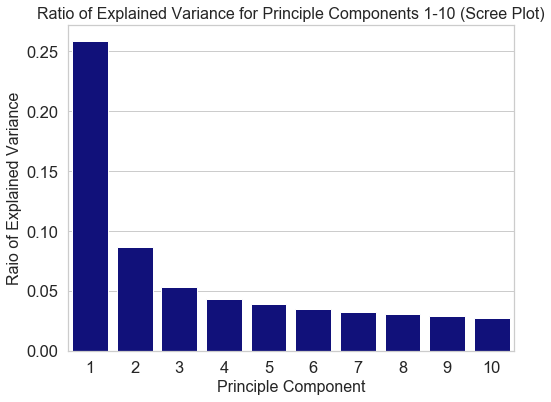

In [185]:
pca = PCA(10)
lex_fit_out = pca.fit(lextranfs_out.T.values)
pca_lexs_out = lex_fit_out.transform(lextranfs_out.T.values)

lexloadings_out = lex_fit_out.components_.T * np.sqrt(lex_fit_out.explained_variance_)
lexloadings_out = pd.DataFrame(lexloadings_out.T, index=np.arange(10)+1, columns=lextranfs_out.index)


plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(10)+1, y=lex_fit_out.explained_variance_ratio_[:10], color='darkblue')
plt.xlabel('Principle Component', size=16)
plt.ylabel('Raio of Explained Variance', size=16)
plt.title('Ratio of Explained Variance for Principle Components 1-10 (Scree Plot)', size=16)
plt.show()

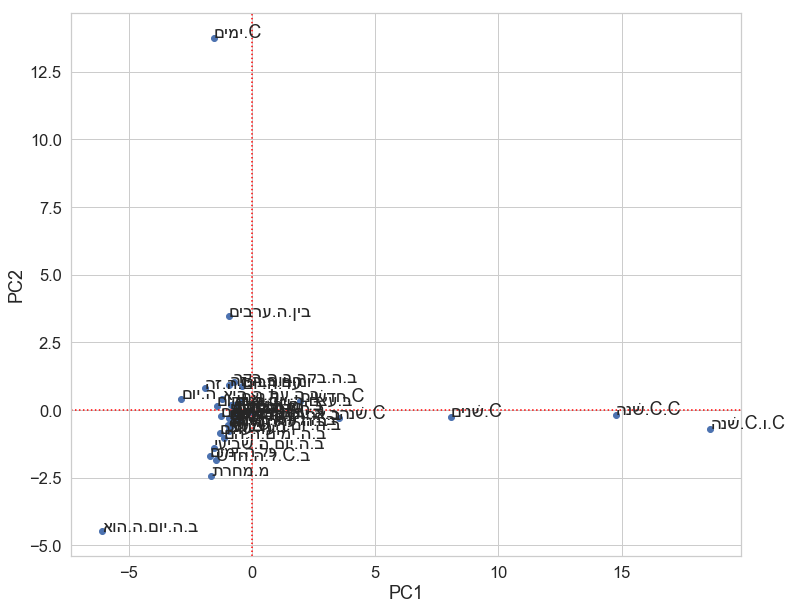

In [186]:
plot_PCA(pca_lexs_out, components=(pca_lexs_out[:,0], pca_lexs_out[:,1]), annoTags=[reverse_hb(token) for token in lextranfs_out.columns])

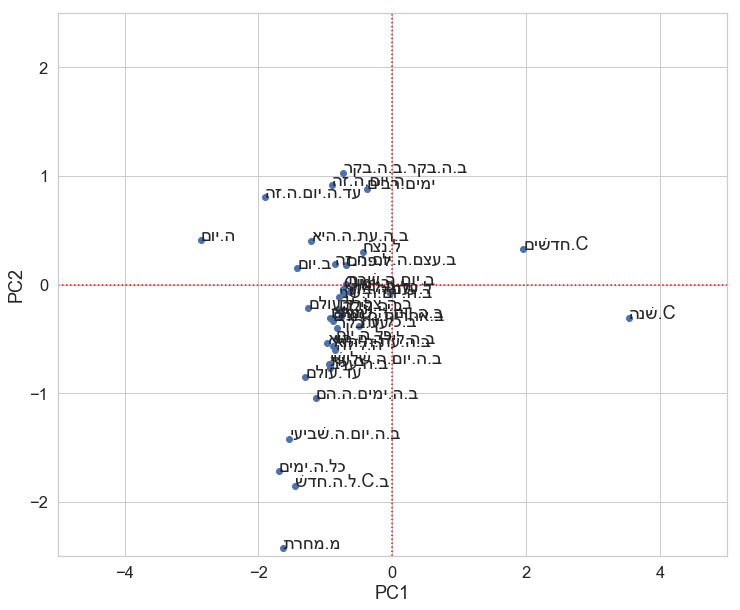

In [198]:
plot_PCA(pca_lexs_out, zoom=((-5, 5, -2.5, 2.5)), components=(pca_lexs_out[:,0], pca_lexs_out[:,1]), annoTags=[reverse_hb(token) for token in lextranfs_out.columns])

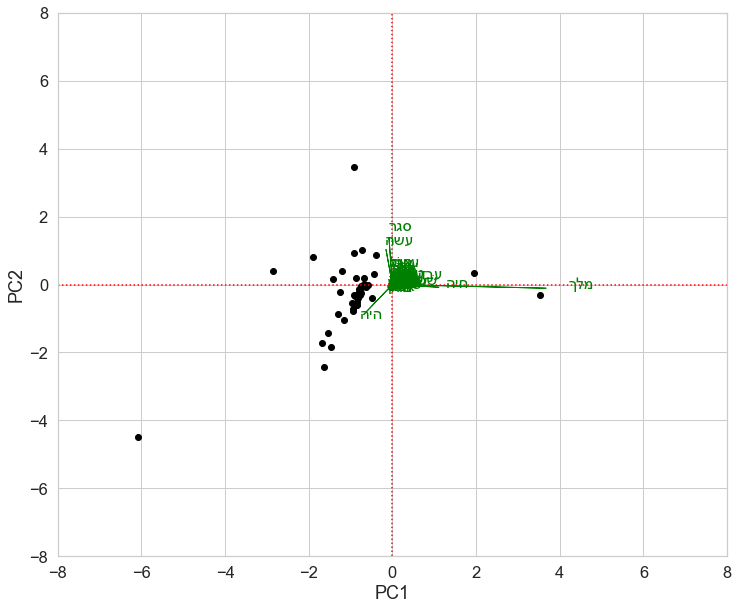

In [188]:
x, y = (pca_lexs_out[:,0], pca_lexs_out[:,1])

# plot coordinates
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black')
plt.xlabel('PC1', size=18)
plt.ylabel('PC2', size=18)
plt.axhline(color='red', linestyle=':')
plt.axvline(color='red', linestyle=':')

zoom = (-8, 8, -8, 8)
plt.xlim(zoom[0], zoom[1])
plt.ylim(zoom[2], zoom[3])

for lex in lexloadings_out:
    x, y = lexloadings_out[lex][:2]
    plt.arrow(0, 0, x, y, color='green')
    
    # handle zooms
    if any([x < zoom[0], x > zoom[1], y < zoom[2], y > zoom[3]]):                
        continue
        
    plt.annotate(reverse_hb(F.lex_utf8.v(L.d(basis2lex[lex], 'word')[0])), xy=(x*1.15, y*1.15), color = 'green', size=16)

#plt.savefig('plots/duration/conj_PCA_biplot.png', dpi=300)
    
plt.show()

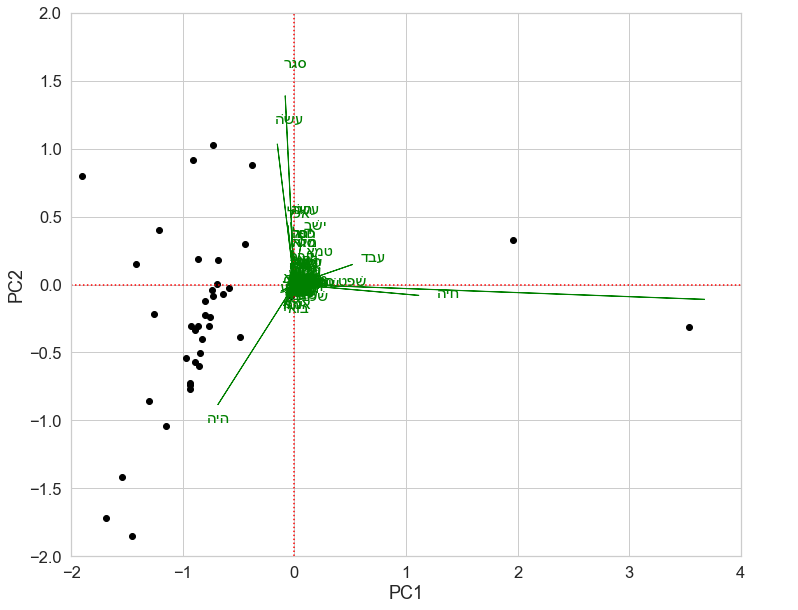

In [189]:
x, y = (pca_lexs_out[:,0], pca_lexs_out[:,1])

# plot coordinates
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black')
plt.xlabel('PC1', size=18)
plt.ylabel('PC2', size=18)
plt.axhline(color='red', linestyle=':')
plt.axvline(color='red', linestyle=':')

zoom = (-2, 4, -2, 2)
plt.xlim(zoom[0], zoom[1])
plt.ylim(zoom[2], zoom[3])

for lex in lexloadings_out:
    x, y = lexloadings_out[lex][:2]
    plt.arrow(0, 0, x, y, color='green')
    
    # handle zooms
    if any([x < zoom[0], x > zoom[1], y < zoom[2], y > zoom[3]]):                
        continue
        
    plt.annotate(reverse_hb(F.lex_utf8.v(L.d(basis2lex[lex], 'word')[0])), xy=(x*1.15, y*1.15), color = 'green', size=16)

#plt.savefig('plots/duration/conj_PCA_biplot.png', dpi=300)
    
plt.show()

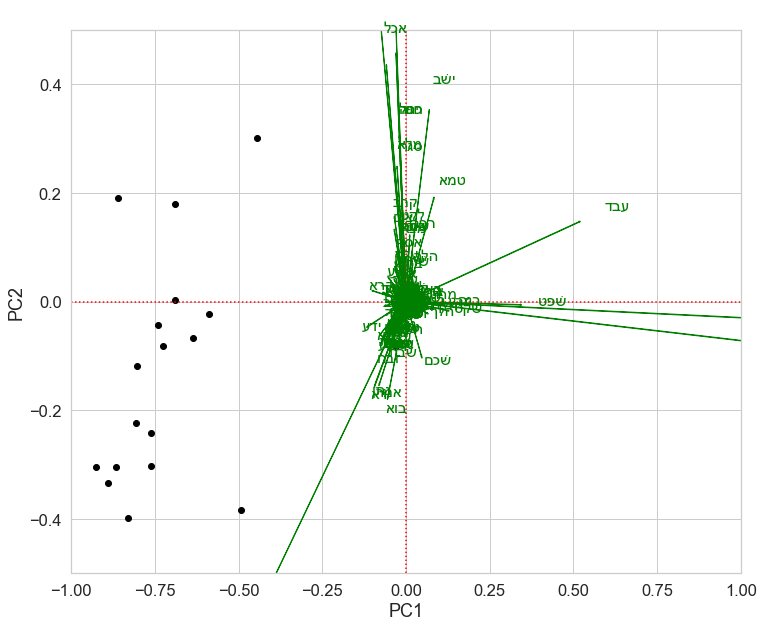

In [190]:
x, y = (pca_lexs_out[:,0], pca_lexs_out[:,1])

# plot coordinates
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black')
plt.xlabel('PC1', size=18)
plt.ylabel('PC2', size=18)
plt.axhline(color='red', linestyle=':')
plt.axvline(color='red', linestyle=':')

zoom = (-1, 1, -0.5, 0.5)
plt.xlim(zoom[0], zoom[1])
plt.ylim(zoom[2], zoom[3])

for lex in lexloadings_out:
    x, y = lexloadings_out[lex][:2]
    plt.arrow(0, 0, x, y, color='green')
    
    # handle zooms
    if any([x < zoom[0], x > zoom[1], y < zoom[2], y > zoom[3]]):                
        continue
        
    plt.annotate(reverse_hb(F.lex_utf8.v(L.d(basis2lex[lex], 'word')[0])), xy=(x*1.15, y*1.15), color = 'green', size=16)

#plt.savefig('plots/duration/conj_PCA_biplot.png', dpi=300)
    
plt.show()

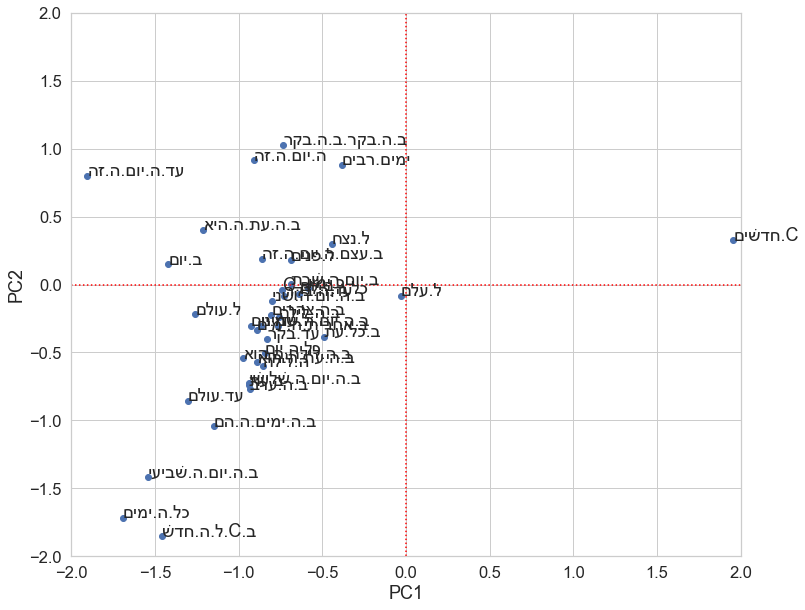

In [195]:
plot_PCA(pca_lexs_out, zoom=((-2, 2, -2, 2)), components=(pca_lexs_out[:,0], pca_lexs_out[:,1]), annoTags=[reverse_hb(token) for token in lextranfs_out.columns])

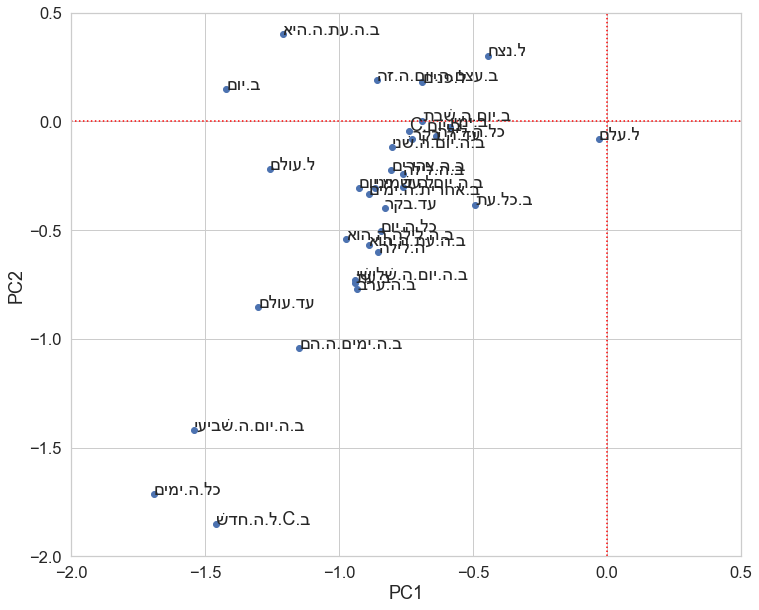

In [196]:
plot_PCA(pca_lexs_out, zoom=((-2, 0.5, -2, 0.5)), components=(pca_lexs_out[:,0], pca_lexs_out[:,1]), annoTags=[reverse_hb(token) for token in lextranfs_out.columns])

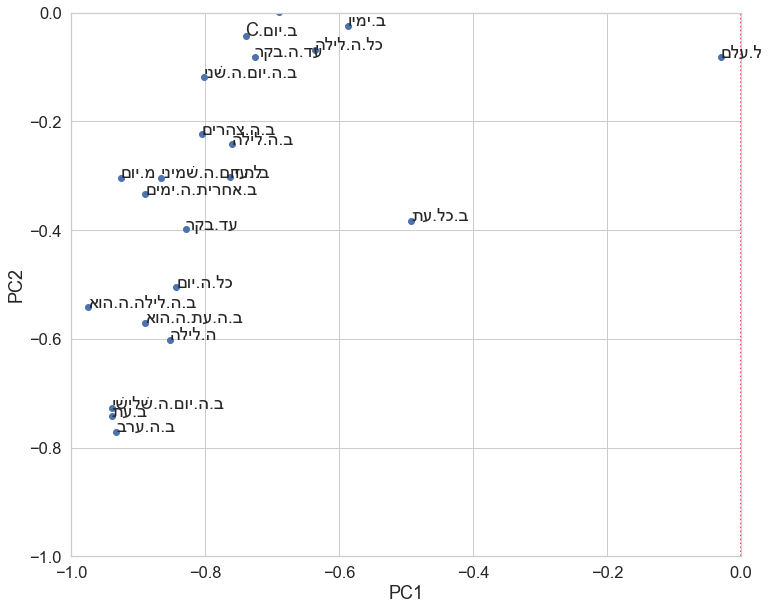

In [197]:
plot_PCA(pca_lexs_out, zoom=((-1, 0, -1, 0)), components=(pca_lexs_out[:,0], pca_lexs_out[:,1]), annoTags=[reverse_hb(token) for token in lextranfs_out.columns])

In [192]:
lexloadings_out.loc[1].sort_values(ascending=False).head(15)

מלך.v1.qal     3.672623
חיה.v1.qal     1.112056
עבד.v1.qal     0.516696
שׁפט.v1.qal    0.341307
בנה.v1.qal     0.134545
שׁקט.v1.qal    0.124853
זרע.v1.qal     0.109415
טמא.v1.qal     0.082328
הלך.v1.hif     0.071842
ישׁב.v1.qal    0.068926
מרד.v1.qal     0.067001
הלך.v1.hit     0.062762
גור.v1.qal     0.048465
צור.v1.qal     0.048465
שׁכם.v1.hif    0.046094
Name: 1, dtype: float64

In [193]:
lexloadings_out.loc[1].sort_values().head(15)

היה.v1.qal    -0.683685
עשׂה.v1.qal   -0.152603
ידע.v1.qal    -0.113962
קרא.v1.qal    -0.097728
ירא.v1.qal    -0.092714
נתן.v1.qal    -0.089632
סגר.v1.hif    -0.082175
אמר.v1.qal    -0.079068
יצא.v1.qal    -0.076665
זבח.v1.qal    -0.074761
ישׁע.v1.hif   -0.073973
כרת.v1.qal    -0.071258
עוד.v1.hif    -0.066342
נגד.v1.hif    -0.062889
שׁמע.v1.qal   -0.062339
Name: 1, dtype: float64

#### Interesting Cases

In [ ]:
A.show((ph,) for ph in token2phrase[''])

### Clustering with Verb Conjugation (Tense) Attraction Scores

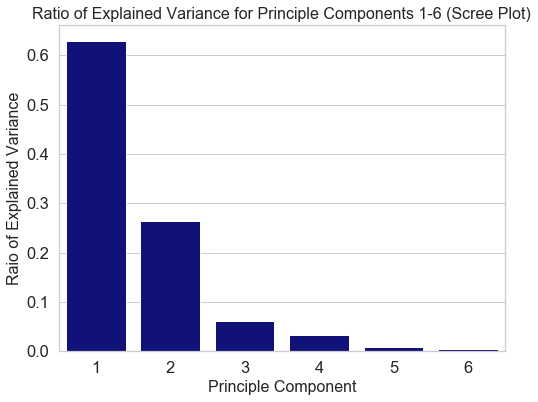

In [94]:
pca = PCA(6)
conj_fit = pca.fit(conjtransf.T.values)
pca_conj = conj_fit.transform(conjtransf.T.values)

conjloadings = conj_fit.components_.T * np.sqrt(conj_fit.explained_variance_)
conjloadings = pd.DataFrame(conjloadings.T, index=np.arange(6)+1, columns=conjtransf.index)


plt.figure(figsize=(8, 6))
sns.barplot(x=np.arange(6)+1, y=conj_fit.explained_variance_ratio_[:6], color='darkblue')
plt.xlabel('Principle Component', size=16)
plt.ylabel('Raio of Explained Variance', size=16)
plt.title('Ratio of Explained Variance for Principle Components 1-6 (Scree Plot)', size=16)
plt.show()

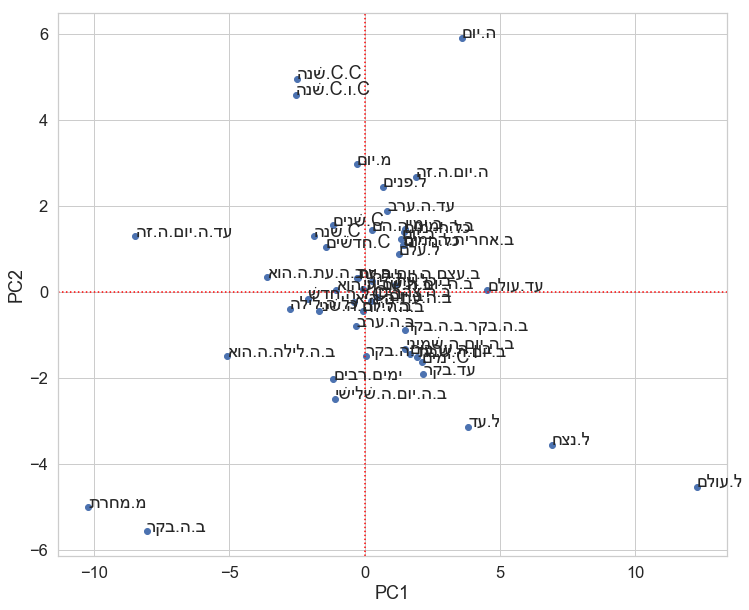

In [99]:
plot_PCA(pca_conj, components=(pca_conj[:,0], pca_conj[:,1]), annoTags=[reverse_hb(token) for token in conjtransf.columns])

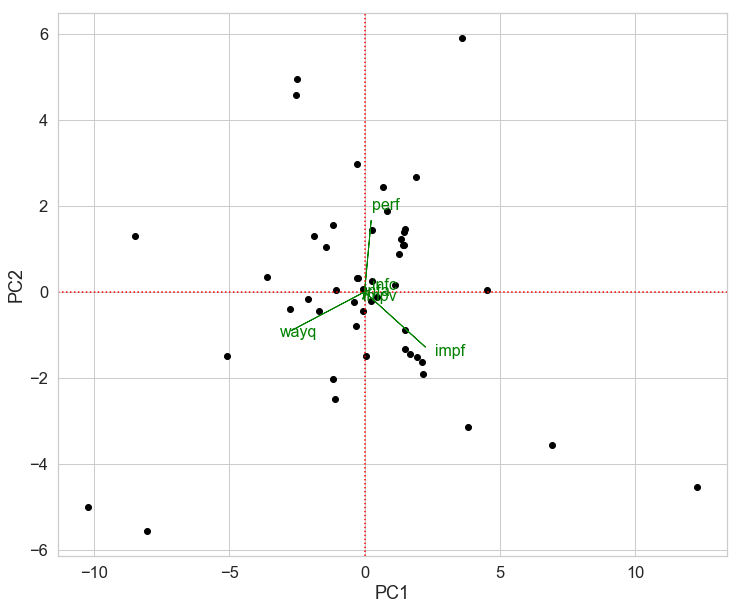

In [147]:
x, y = (pca_conj[:,0], pca_conj[:,1])

# plot coordinates
plt.figure(figsize=(12, 10))
plt.scatter(x, y, color='black')
plt.xlabel('PC1', size=18)
plt.ylabel('PC2', size=18)
plt.axhline(color='red', linestyle=':')
plt.axvline(color='red', linestyle=':')

for verbconj in conjloadings:
    x, y = conjloadings[verbconj][:2]
    plt.arrow(0, 0, x, y, color='green')
    plt.annotate(verbconj, xy=(x*1.15, y*1.15), color = 'green', size=16)

plt.savefig('plots/duration/conj_PCA_biplot.png', dpi=300)
    
plt.show()

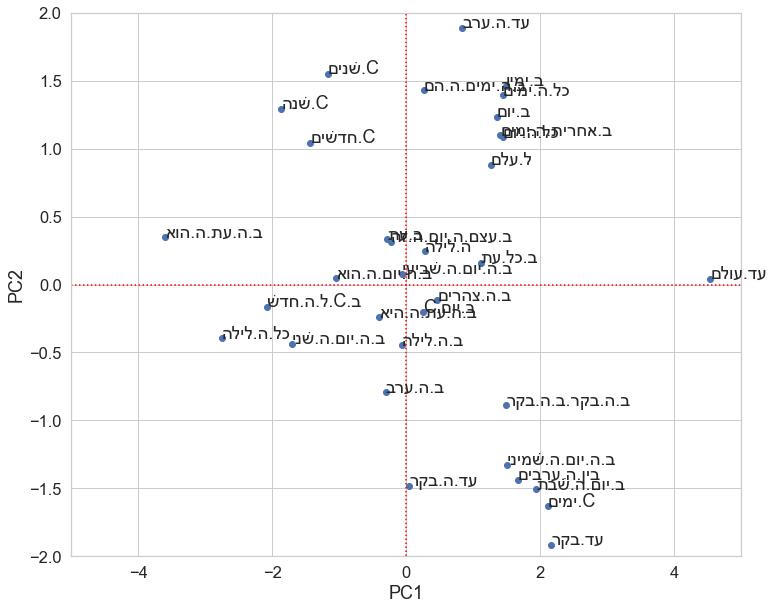

In [101]:
plot_PCA(pca_conj, components=(pca_conj[:,0], pca_conj[:,1]), zoom=((-5, 5, -2, 2)), annoTags=[reverse_hb(token) for token in conjtransf.columns])

#### Loading Scores for Conjugations

In [97]:
conjloadings.loc[1].sort_values(ascending=False)

impf    2.251016
infc    0.247658
perf    0.244524
infa   -0.024907
impv   -0.062050
wayq   -2.718891
Name: 1, dtype: float64

In [98]:
conjloadings.loc[2].sort_values(ascending=False)

perf    1.660644
infc    0.057345
infa   -0.077283
impv   -0.171035
wayq   -0.902955
impf   -1.282907
Name: 2, dtype: float64

#### Interesting Cases

In [102]:
A.show((ph,) for ph in token2phrase['ב.ה.בקר.ב.ה.בקר'])



**result** *1*





**result** *2*





**result** *3*





**result** *4*





**result** *5*





**result** *6*





**result** *7*





**result** *8*





**result** *9*





**result** *10*





**result** *11*





**result** *12*



# Groupings

In [53]:
# all
print('searching total NP time phrases...')
all_np_time = A.search('phrase function=Time typ=NP', shallow=True)

print('searching quantified...')
# group 1, quantified
quant_np = A.search('''

p:phrase function=Time typ=NP
/with/
    word sem_set=quant
/or/
    word nu=pl|du
/or/
    w1:word
    w2:word
    p <head- w1
    p <head- w2
    w1 # w2
    
lex
    w1
    w2
/-/
    
''', shallow=True)

print('searching demonstratives...')
# group 2, demonstrated
demon_np = A.search('''

phrase function=Time typ=NP
/with/
    word pdp=prde
/or/
    =: word pdp=art
/-/

/without/
    word sem_set=quant
/-/
''', shallow=True)

print('searching unmarked...')
# group 3, unmarked
unmarked_np = A.search('''

p:phrase function=Time typ=NP
/with/
    <head- w1:word nu#pl|du
    p =: w1
    p := w1
/-/
''', shallow=True)

found_results = set(quant_np)|set(demon_np)|set(unmarked_np)

print()
print(f'found: {len(found_results)} / {len(all_np_time)}')

searching total NP time phrases...
  0.27s 905 results
searching quantified...
  1.42s 615 results
searching demonstratives...
  0.67s 251 results
searching unmarked...
  1.05s 12 results

found: 875 / 905


In [54]:
groups = {'quant': quant_np, 'demon': demon_np, 'unmarked':unmarked_np}

print('overlap between sets:')
for groupi, resi in groups.items():
    print(groupi)
    for groupj, resj in groups.items():
        
        if groupi == groupj:
            continue
            
        print(f'\t{groupj}: {len(set(resi)&set(resj))}')

overlap between sets:
quant
	demon: 3
	unmarked: 0
demon
	quant: 3
	unmarked: 0
unmarked
	quant: 0
	demon: 0


In [58]:
len(set(all_np_time)-found_results)

30

**NOTES**

These groupings indeed distinguish the most amongst the dataset, though the patterns include a diverse group of searches, putting plurals and quantifieds together, for instance. These should probably be separated out into individual groups. 

## Building Test Sets

In [21]:
durative = A.search('''

clause
/without/
    phrase function=Objc|Cmpl
/-/

    phrase function=Pred|PreS
    phrase function=Time typ=NP
    /without/
        word pdp=prep|prde|advb
    /-/
    /without/
        =: word pdp=art
    /-/
''')

  0.72s 199 results


In [61]:
#A.show(durative, withNodes=True, start=100, end=200)

In [29]:
simultaneous = A.search('''

clause
/without/
    phrase function=Objc|Cmpl
/-/

    phrase function=Pred|PreS
    phrase function=Time typ=PP
    /without/
        word pdp=prde|advb
    /-/
        <head- word lex=B
''')

  1.24s 414 results


In [62]:
#A.show(simultaneous, withNodes=True, start=0, end=100)

In [32]:
demonstrative = A.search('''

clause
/without/
    phrase function=Objc|Cmpl
/-/

    phrase function=Pred|PreS
    phrase function=Time
    /without/
        word pdp=advb
    /-/
        word pdp=prde
    
''')

  1.12s 222 results


In [63]:
#A.show(demonstrative, withNodes=True, start=0, end=100)

### Distinguishing from "Purposive Extent"
The atelic time duration is closely related to the "purposive extent," a function illustrated by the construction:

> Sibylle went to Paris for five years. (Haspelmath 1997: 128)

Haspelmath explains further:

> In purposive-extent constructions, the verbal event is not atelic, but the adverbial measures the length of the state resulting from this event. (Haspelmath 1997: 128)

Fuhs describes his method of dealing with this construction:

> In coding, I followed Smith’s suggestion to classify single for-phrases as instances of the durative construction, whereas in double marking, the second phrase was coded as a ‘purpositive extend’ [sic] (Haspelmath 1997: 128; Smith 1997: 114). After manually clearing the set, a total of 671 true instances of the English Durative Adverbial remained, which occurred in clauses in which no other aspect constructions in the periphery were present that could influence the predicate construal. This set was then used for a Collostructional Analysis. (Fuhs 2010: 145)

This procedure is the most vulnerable aspect of Fuhs's study. The purposive extent can occur without the doubling mentioned by Smith. This means that most of these cases would have to be manually sorted, and Fuhs himself would have had to decide whether a time phrase was purposive or not. Smith's criteria for purposive extent presents a circularity issue for Fuhs's manual sorting procedure:

> What triggers the shift [from telic event to atelic] is the incompatibility between the value of the verb constellations (telic) and the adverbials (atelic). (Smith 1997: 113).

Yet, the "compatibility" between the verb and the adverbials is precisely what Fuhs intends to measure. If he had used these notions in his manual sorting, they would might have affected the dataset he obtains.

### From...To Durations (מן...עד)